# Imports

In [283]:
import pandas as pd
import numpy as np
from scipy.stats import zscore
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
import plotly.express as px
import plotly.graph_objects as go
sns.set(rc={'figure.figsize':(25,10)})
from prophet import Prophet
from sklearn.metrics import mean_squared_error
import numpy as np
from sklearn.metrics import mean_absolute_percentage_error
import holidays

# Import prepared DF

In [455]:
# Load prepared dataset
df_days = pd.read_csv("../prepared_data/01_06_2021_to_20_06_2023_prepared_df_25std.csv")
print(df_days.head())

         date  nb_cars  nb_cars_cxl  nb_bookings  nb_bookings_cxl  \
0  2021-06-01        6            0            5                0   
1  2021-06-02       10            0           13                0   
2  2021-06-03       15            0            6                0   
3  2021-06-04       18            0           15                0   
4  2021-06-05       18            0            5                1   

   hourly rate  WE package  1 week package  1 month package  other package  \
0            1           0               4                1              0   
1            3           0               6                1              0   
2            7           0               7                1              0   
3           10           0               7                1              0   
4            6           9               3                0              0   

   ...  12H à 15H  0H à 6H  18H à 24H  +24h  06:00 24:00  00:30 06:00  \
0  ...          2        1          1     6

# Prophet nb of cars

## Just the nb of cars as y

In [418]:
df_prophet_cars = df_days[['date', 'nb_cars']]
df_prophet_cars = df_prophet_cars.rename(columns={'date': 'ds', 'nb_cars': 'y'})
df_prophet_cars.head()


,ds,y
0,2021-06-01,6
1,2021-06-02,10
2,2021-06-03,15
3,2021-06-04,18
4,2021-06-05,18


In [419]:
# Define the split percentages
train_percentage = 0.9
test_percentage = 0.05
validation_percentage = 0.05

# Calculate the number of rows for each set
total_rows = len(df_prophet_cars)
train_rows = int(total_rows * train_percentage)
test_rows = int(total_rows * test_percentage)
validation_rows = total_rows - train_rows - test_rows

# Split the data into train, test, and validation sets
train_set = df_prophet_cars[:train_rows]
test_set = df_prophet_cars[train_rows:train_rows + test_rows]
validation_set = df_prophet_cars[train_rows + test_rows:]

print("train_rows:", train_rows)
print("test_rows:", test_rows)
print("validation_rows:", validation_rows)
print()

train_rows: 675
test_rows: 37
validation_rows: 38



In [420]:
model = Prophet()
model.fit(df_prophet_cars)

# Create future dates for the test and validation periods
future_test = model.make_future_dataframe(periods=len(test_set))
future_validation = model.make_future_dataframe(periods=len(validation_set))

# Predict on the test and validation sets
forecast_test = model.predict(future_test)
forecast_validation = model.predict(future_validation)


21:37:10 - cmdstanpy - INFO - Chain [1] start processing
21:37:10 - cmdstanpy - INFO - Chain [1] done processing


In [421]:
# Calculate RMSE for the test set
y_true_test = test_set['y']
y_pred_test = forecast_test['yhat'].tail(len(test_set))
rmse_test = np.sqrt(mean_squared_error(y_true_test, y_pred_test))
print("RMSE for the test set:", rmse_test)

RMSE for the test set: 10.931296537698802


In [422]:
mape_test = mean_absolute_percentage_error(y_true_test, y_pred_test) * 100
print("MAPE for the test set:", mape_test)

MAPE for the test set: 39.171368810798


## Forecast nb of cars with french holidays (from holidays package)

In [423]:
df_prophet_cars = df_days.drop(['nb_cars_cxl', 'nb_bookings', 'nb_bookings_cxl'], axis=1)
df_prophet_cars = df_prophet_cars.rename(columns={'date': 'ds', 'nb_cars': 'y'})

# Add the 'holiday' column
fr_holidays = holidays.France()
df_prophet_cars['holiday'] = df_prophet_cars['ds'].apply(lambda x: x in fr_holidays)
df_prophet_cars['ds'] = pd.to_datetime(df_prophet_cars['ds'])

# Create a separate DataFrame for holidays
holidays_df = df_prophet_cars[df_prophet_cars['holiday']]
holidays_df['holiday'] = 'Holiday'

model = Prophet(holidays=holidays_df)
model.fit(df_prophet_cars)

# Create future dates (365 days)
future = model.make_future_dataframe(periods=365)
future.tail()

# Predict
forecast = model.predict(future)
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

# Calculate train, test, validation sets and evaluate accuracy
train_percentage = 0.9
test_percentage = 0.05
validation_percentage = 0.05

total_rows = len(df_prophet_cars)
train_rows = int(total_rows * train_percentage)
test_rows = int(total_rows * test_percentage)
validation_rows = total_rows - train_rows - test_rows

train_set = df_prophet_cars[:train_rows]
test_set = df_prophet_cars[train_rows:train_rows + test_rows]
validation_set = df_prophet_cars[train_rows + test_rows:]

model = Prophet(holidays=holidays_df)
model.fit(train_set)

future_test = model.make_future_dataframe(periods=len(test_set))
future_validation = model.make_future_dataframe(periods=len(validation_set))

forecast_test = model.predict(future_test)
forecast_validation = model.predict(future_validation)

y_true_test = test_set['y']
y_pred_test = forecast_test['yhat'].tail(len(test_set))
rmse_test = np.sqrt(mean_squared_error(y_true_test, y_pred_test))





/var/folders/gn/32bg35111_q711w0ydw7_2rc0000gp/T/ipykernel_83026/641127344.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  holidays_df['holiday'] = 'Holiday'
/Users/anaisetienne/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/prophet/forecaster.py:175: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.holidays['ds'] = pd.to_datetime(self.holidays['ds'])
21:37:19 - cmdstanpy - INFO - Chain [1] start processing
21:37:19 - cmdstanpy - INFO - Chain [1] done processing
/Users/anaisetienne/

In [424]:
print("RMSE for the test set:", rmse_test)

mape_test = mean_absolute_percentage_error(y_true_test, y_pred_test) * 100
print("MAPE for the test set:", mape_test)

RMSE for the test set: 8.065086066124412
MAPE for the test set: 23.47034335202148


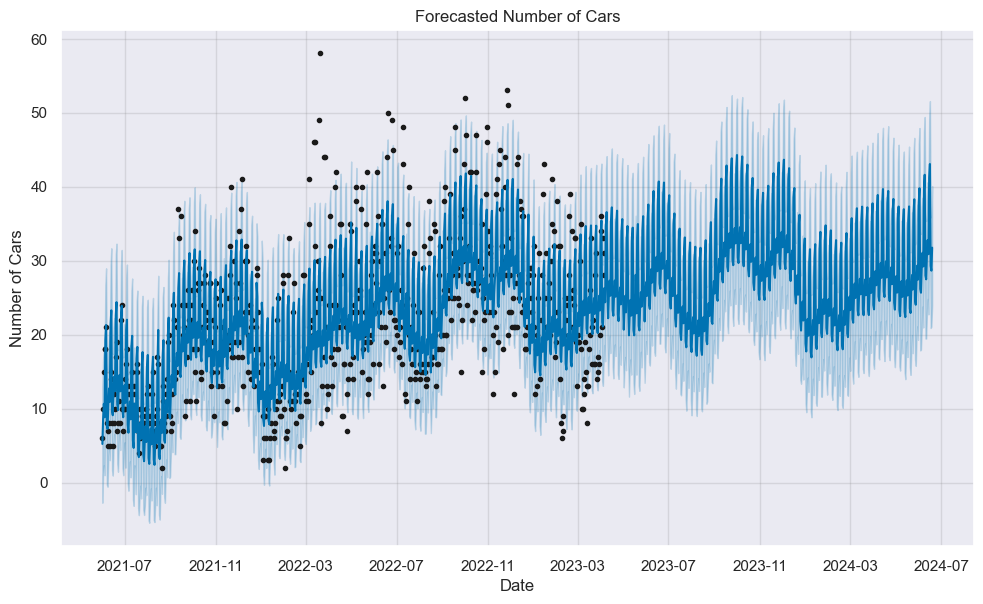

In [425]:
# Plot the graph
fig1 = model.plot(forecast)
plt.xlabel('Date')
plt.ylabel('Number of Cars')
plt.title('Forecasted Number of Cars')

plt.show()

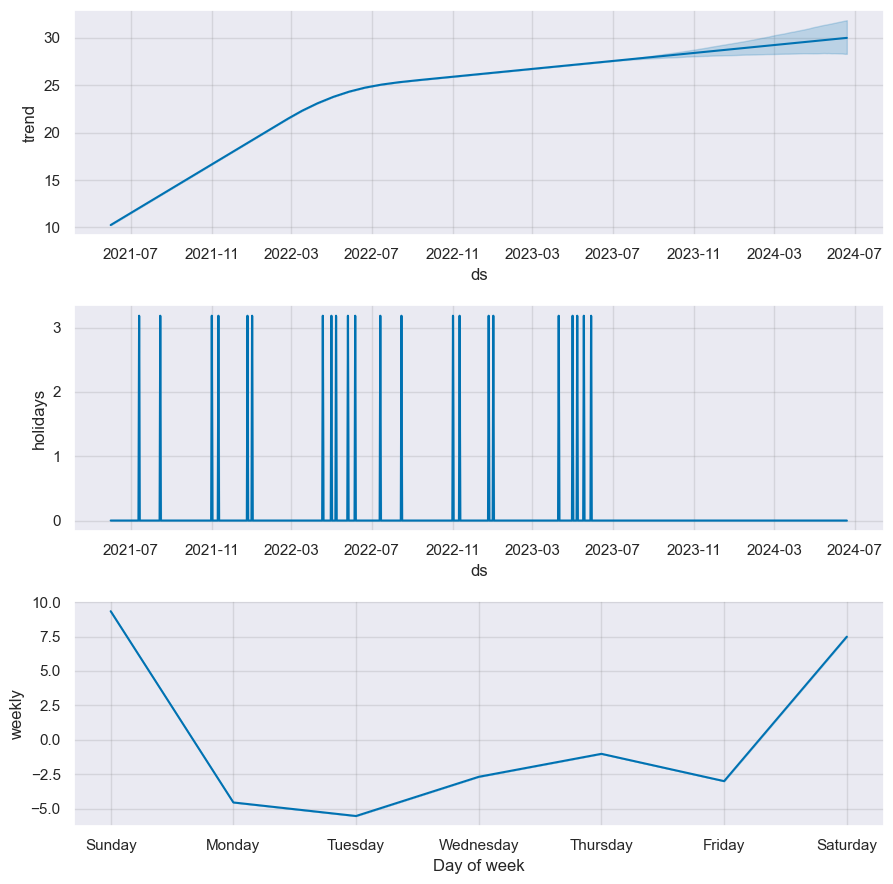

In [426]:
# Explain seasonality
fig2 = model.plot_components(forecast)


# Prophet nb of bookings

## Forecast nb of bookings 

In [427]:
df_prophet_bookings = df_days.drop(['nb_cars_cxl', 'nb_cars', 'nb_bookings_cxl'], axis=1)
df_prophet_bookings = df_prophet_bookings.rename(columns={'date': 'ds', 'nb_bookings': 'y'})
df_prophet_bookings.head()

,ds,y,hourly rate,WE package,1 week package,1 month package,other package,2 weeks package,turnover,discount,...,12H à 15H,0H à 6H,18H à 24H,+24h,06:00 24:00,00:30 06:00,00:00 00:30,strike,holidays,vacation
0,2021-06-01,5,1,0,4,1,0,0,264.0,0.0,...,2,1,1,6,0,0,0,0,0,0
1,2021-06-02,13,3,0,6,1,0,0,342.9,0.0,...,2,1,1,10,0,0,0,0,0,0
2,2021-06-03,6,7,0,7,1,0,0,209.4,0.0,...,2,1,1,15,0,0,0,0,0,0
3,2021-06-04,15,10,0,7,1,0,0,411.2,291.2,...,3,2,1,18,0,0,0,0,0,0
4,2021-06-05,5,6,9,3,0,0,0,131.2,59.2,...,8,0,0,18,0,0,0,0,0,0


In [428]:
# Define the split percentages
train_percentage = 0.9
test_percentage = 0.05
validation_percentage = 0.05

# Calculate the number of rows for each set
total_rows = len(df_prophet_cars)
train_rows = int(total_rows * train_percentage)
test_rows = int(total_rows * test_percentage)
validation_rows = total_rows - train_rows - test_rows

# Split the data into train, test, and validation sets
train_set = df_prophet_bookings[:train_rows]
test_set = df_prophet_bookings[train_rows:train_rows + test_rows]
validation_set = df_prophet_bookings[train_rows + test_rows:]

print("train_rows:", train_rows)
print("test_rows:", test_rows)
print("validation_rows:", validation_rows)
print()

train_rows: 675
test_rows: 37
validation_rows: 38



In [429]:
model2 = Prophet()
model2.fit(train_set)

21:38:23 - cmdstanpy - INFO - Chain [1] start processing
21:38:23 - cmdstanpy - INFO - Chain [1] done processing


In [430]:
# Create future dates for the test and validation periods
future_test = model2.make_future_dataframe(periods=len(test_set))
future_validation = model2.make_future_dataframe(periods=len(validation_set))

# Predict on the test and validation sets
forecast_test = model2.predict(future_test)
forecast_validation = model2.predict(future_validation)

In [431]:
# Calculate RMSE for the test set
y_true_test2 = test_set['y']
y_pred_test2 = forecast_test['yhat'].tail(len(test_set))
rmse_test2 = np.sqrt(mean_squared_error(y_true_test2, y_pred_test2))
print("RMSE for the test set:", rmse_test2)

RMSE for the test set: 5.039202037924901


In [432]:
mape_test2 = mean_absolute_percentage_error(y_true_test2, y_pred_test2) * 100
print("MAPE for the test set:", mape_test2)

MAPE for the test set: 4.779943951235082e+16


## Forecast nb of bookings with holidays (from holidays package)

In [433]:
df_prophet_bookings = df_days.drop(['nb_cars_cxl', 'nb_cars', 'nb_bookings_cxl'], axis=1)
df_prophet_bookings = df_prophet_bookings.rename(columns={'date': 'ds', 'nb_bookings': 'y'})

# Add the 'holiday' column
fr_holidays = holidays.France()
df_prophet_bookings['holiday'] = df_prophet_bookings['ds'].apply(lambda x: x in fr_holidays)
df_prophet_bookings['ds'] = pd.to_datetime(df_prophet_bookings['ds'])

# Create a separate DataFrame for holidays
holidays_df = df_prophet_bookings[df_prophet_bookings['holiday'] == True]
holidays_df['holiday'] = 'Holiday'

model = Prophet(holidays=holidays_df)
model.fit(df_prophet_bookings)

# Create future dates (365 days)
future = model.make_future_dataframe(periods=365)
future.tail()

# Predict
forecast = model.predict(future)
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

# Calculate train, test, validation sets and evaluate accuracy
train_percentage = 0.9
test_percentage = 0.05
validation_percentage = 0.05

total_rows = len(df_prophet_bookings)
train_rows = int(total_rows * train_percentage)
test_rows = int(total_rows * test_percentage)
validation_rows = total_rows - train_rows - test_rows

train_set = df_prophet_bookings[:train_rows]
test_set = df_prophet_bookings[train_rows:train_rows + test_rows]
validation_set = df_prophet_bookings[train_rows + test_rows:]

model = Prophet(holidays=holidays_df)
model.fit(train_set)

future_test = model.make_future_dataframe(periods=len(test_set))
future_validation = model.make_future_dataframe(periods=len(validation_set))

forecast_test = model.predict(future_test)
forecast_validation = model.predict(future_validation)

y_true_test = test_set['y']
y_pred_test = forecast_test['yhat'].tail(len(test_set))
rmse_test = np.sqrt(mean_squared_error(y_true_test, y_pred_test))


/var/folders/gn/32bg35111_q711w0ydw7_2rc0000gp/T/ipykernel_83026/1019627881.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  holidays_df['holiday'] = 'Holiday'
/Users/anaisetienne/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/prophet/forecaster.py:175: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.holidays['ds'] = pd.to_datetime(self.holidays['ds'])
21:38:33 - cmdstanpy - INFO - Chain [1] start processing
21:38:33 - cmdstanpy - INFO - Chain [1] done processing
/Users/anaisetienne

In [434]:
print(df_prophet_bookings.head())

print("RMSE for the test set:", rmse_test)

mape_test = mean_absolute_percentage_error(y_true_test, y_pred_test) * 100
print("MAPE for the test set:", mape_test)

          ds   y  hourly rate  WE package  1 week package  1 month package  \
0 2021-06-01   5            1           0               4                1   
1 2021-06-02  13            3           0               6                1   
2 2021-06-03   6            7           0               7                1   
3 2021-06-04  15           10           0               7                1   
4 2021-06-05   5            6           9               3                0   

   other package  2 weeks package  turnover  discount  ...  0H à 6H  \
0              0                0     264.0       0.0  ...        1   
1              0                0     342.9       0.0  ...        1   
2              0                0     209.4       0.0  ...        1   
3              0                0     411.2     291.2  ...        2   
4              0                0     131.2      59.2  ...        0   

   18H à 24H  +24h  06:00 24:00  00:30 06:00  00:00 00:30  strike  holidays  \
0          1     6       

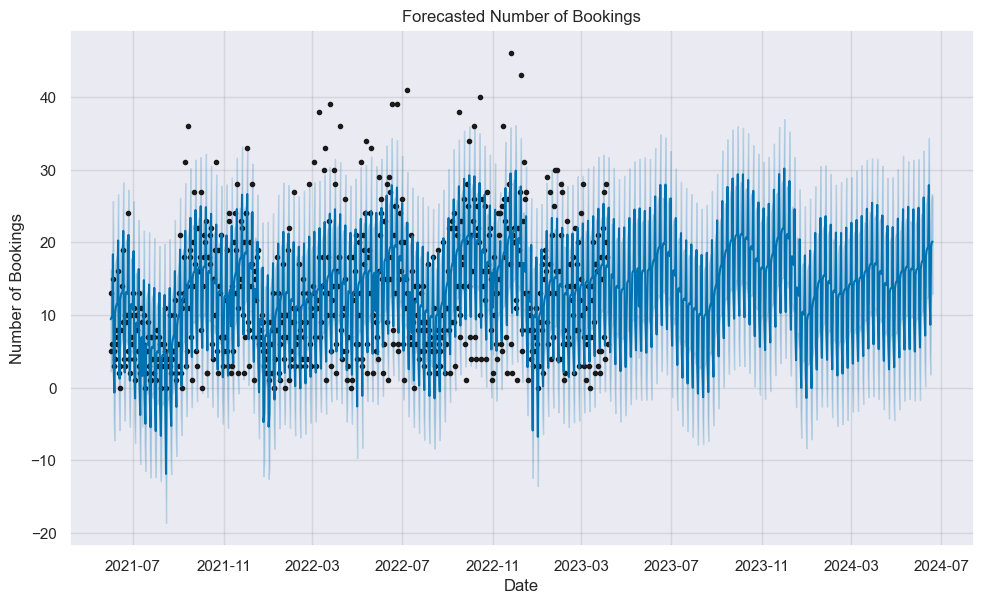

In [435]:
# Plot the graph
fig1 = model.plot(forecast)
plt.xlabel('Date')
plt.ylabel('Number of Bookings')
plt.title('Forecasted Number of Bookings')

plt.show()

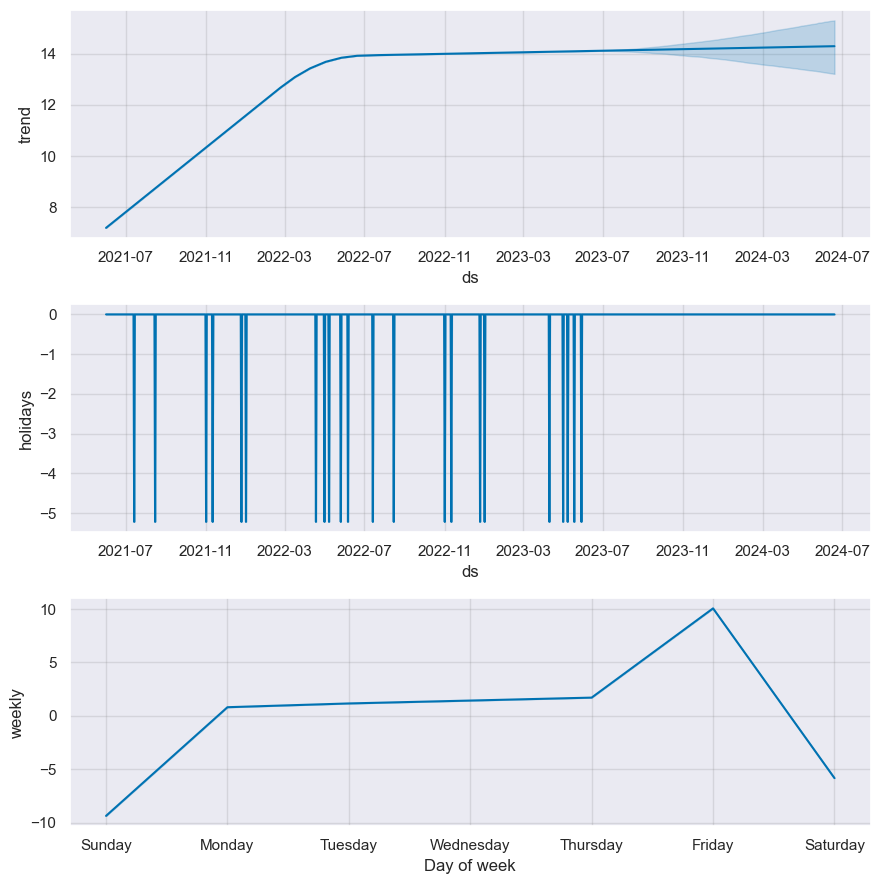

In [436]:
# Explain seasonality
fig2 = model.plot_components(forecast)

In [437]:
df_prophet_cars = df_days[['date', 'nb_cars', 'booking_fees']]
df_prophet_cars = df_prophet_cars.rename(columns={'date': 'ds', 'nb_cars': 'y'})
df_prophet_cars.head()

# Define the split percentages
train_percentage = 0.9
test_percentage = 0.05
validation_percentage = 0.05

# Calculate the number of rows for each set
total_rows = len(df_prophet_cars)
train_rows = int(total_rows * train_percentage)
test_rows = int(total_rows * test_percentage)
validation_rows = total_rows - train_rows - test_rows

# Split the data into train, test, and validation sets
train_set = df_prophet_cars[:train_rows]
test_set = df_prophet_cars[train_rows:train_rows + test_rows]
validation_set = df_prophet_cars[train_rows + test_rows:]

print("train_rows:", train_rows)
print("test_rows:", test_rows)
print("validation_rows:", validation_rows)
print()

model = Prophet()
model.add_regressor('booking_fees')  # Add exogenous variable
model.fit(df_prophet_cars)



21:39:03 - cmdstanpy - INFO - Chain [1] start processing
21:39:03 - cmdstanpy - INFO - Chain [1] done processing


train_rows: 675
test_rows: 37
validation_rows: 38



In [443]:
# Create future dates for the test and validation periods
future_test = model.make_future_dataframe(periods=len(test_set))
future_test['booking_fees'] = np.concatenate((np.zeros(len(train_set)), df_prophet_cars['booking_fees'].values[-len(test_set):]))

future_validation = model.make_future_dataframe(periods=len(validation_set))
future_validation['booking_fees'] = np.concatenate((np.zeros(len(train_set) + len(test_set)), df_prophet_cars['booking_fees'].values[-len(validation_set):]))

future_test['booking_fees'] = future_test['booking_fees'][:len(test_set)]
future_validation['booking_fees'] = future_validation['booking_fees'][:len(validation_set)]


# Predict on the test and validation sets
forecast_test = model.predict(future_test)
forecast_validation = model.predict(future_validation)

# Calculate RMSE for the test set
y_true_test = test_set['y']
y_pred_test = forecast_test['yhat'].tail(len(test_set))
rmse_test = np.sqrt(mean_squared_error(y_true_test, y_pred_test))
print("RMSE for the test set:", rmse_test)

mape_test = mean_absolute_percentage_error(y_true_test, y_pred_test) * 100
print("MAPE for the test set:", mape_test)

ValueError: Length of values (712) does not match length of index (787)

In [459]:
df_prophet_cars = df_days[['date', 'nb_cars', 'booking_fees']]
df_prophet_cars = df_prophet_cars.rename(columns={'date': 'ds', 'nb_cars': 'y'})
mean_booking_fees = df_prophet_cars['booking_fees'].mean()
df_prophet_cars['booking_fees'].fillna(mean_booking_fees, inplace=True)
df_prophet_cars.head()

model = Prophet()
model.add_regressor('booking_fees')  # Add exogenous variable
model.fit(df_prophet_cars)

# Create future dates for the test and validation periods
future_test = model.make_future_dataframe(periods=len(test_set))
future_test['booking_fees'] = np.concatenate((np.full(len(df_prophet_cars), mean_booking_fees), test_set['booking_fees'].values))

future_validation = model.make_future_dataframe(periods=len(validation_set))
future_validation['booking_fees'] = np.full(len(future_validation), mean_booking_fees)

# Update booking_fees for the corresponding rows in future_test and future_validation
future_test['booking_fees'] = future_test['booking_fees'][:len(test_set)]
future_validation['booking_fees'] = future_validation['booking_fees'][:len(validation_set)]

# Predict on the test and validation sets
forecast_test = model.predict(future_test)
forecast_validation = model.predict(future_validation)

# Calculate RMSE for the test set
y_true_test = test_set['y']
y_pred_test = forecast_test['yhat'].tail(len(test_set))
rmse_test = np.sqrt(mean_squared_error(y_true_test, y_pred_test))
print("RMSE for the test set:", rmse_test)

mape_test = mean_absolute_percentage_error(y_true_test, y_pred_test) * 100
print("MAPE for the test set:", mape_test)



22:12:09 - cmdstanpy - INFO - Chain [1] start processing
22:12:09 - cmdstanpy - INFO - Chain [1] done processing


ValueError: Found NaN in column 'booking_fees'

In [463]:
print(df_prophet_cars.tail())


             ds   y  booking_fees
745  2023-06-16  28          84.0
746  2023-06-17  36          27.0
747  2023-06-18  36           6.0
748  2023-06-19  21          42.0
749  2023-06-20  23          39.0


Correlation between booking fees and the number of bookings: 0.04777872987569455


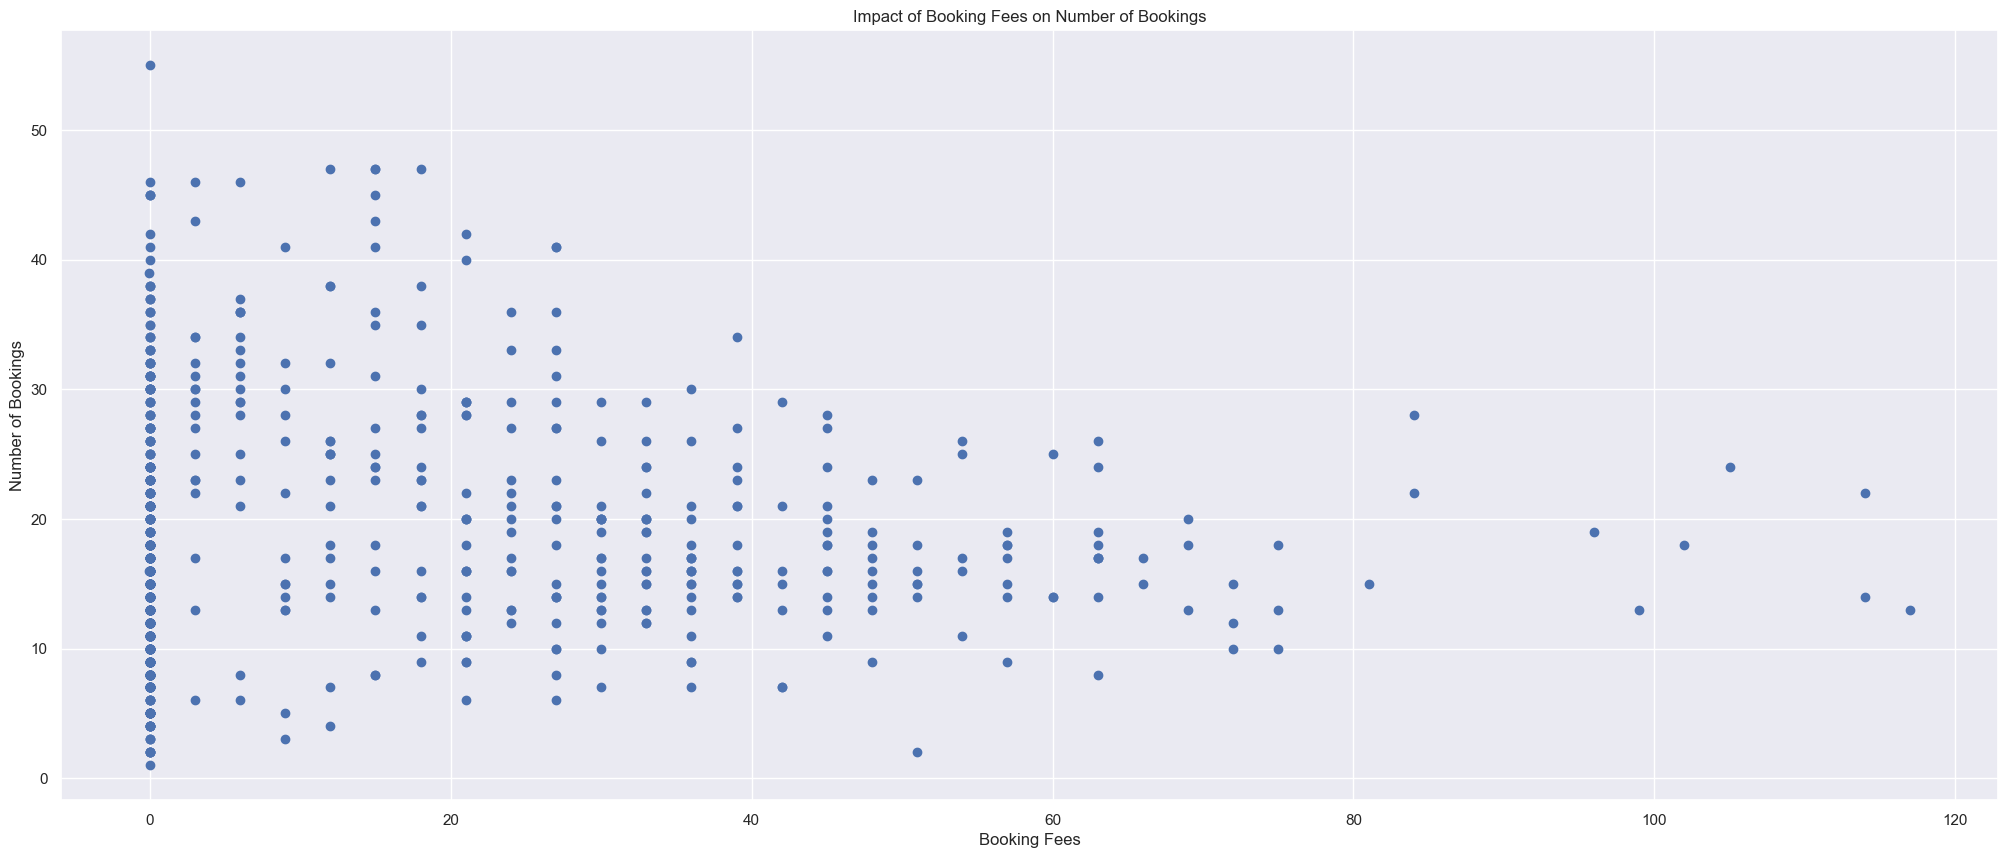

In [464]:
import pandas as pd
import matplotlib.pyplot as plt

# Calculate the correlation between booking fees and the number of bookings
correlation = df_prophet_cars['booking_fees'].corr(df_prophet_cars['y'])
print(f"Correlation between booking fees and the number of bookings: {correlation}")

# Create a scatter plot to visualize the relationship
plt.scatter(df_prophet_cars['booking_fees'], df_prophet_cars['y'])
plt.xlabel('Booking Fees')
plt.ylabel('Number of Bookings')
plt.title('Impact of Booking Fees on Number of Bookings')
plt.show()